<a href="https://colab.research.google.com/github/shakib68/NYC-taxi-capstone/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

**Importing  libraries**

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import  seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading data**

In [3]:
df=pd.read_csv("/content/drive/MyDrive/AlmaBetter/capstone project 2/Copy of NYC Taxi Data.csv")


In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


**Checking Datatype in our Dataset**

In [6]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

**Checking missing value**

In [8]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Series([], dtype: float64)


**Here you can see there is no missing value in our dataset, So will proceed for solution and analysis**

**Importing geopy library to calculate distance**


In [7]:
from geopy.distance import great_circle

**Calculte distance betwee pickup and dropoff points**

In [9]:
#Calculte distance betwee pickup and dropoff points
def distance_cal(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [10]:
# Calculating distance for each trip
df['distance'] = df.apply(lambda df: distance_cal(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'] ), axis=1)


In [11]:
df['distance']

0          1.498523
1          1.805510
2          6.385108
3          1.485501
4          1.188590
             ...   
1458639    1.225082
1458640    6.049844
1458641    7.824617
1458642    1.092565
1458643    1.134044
Name: distance, Length: 1458644, dtype: float64

**converting it to datetime**

In [12]:
#convert it to datetime
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [13]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

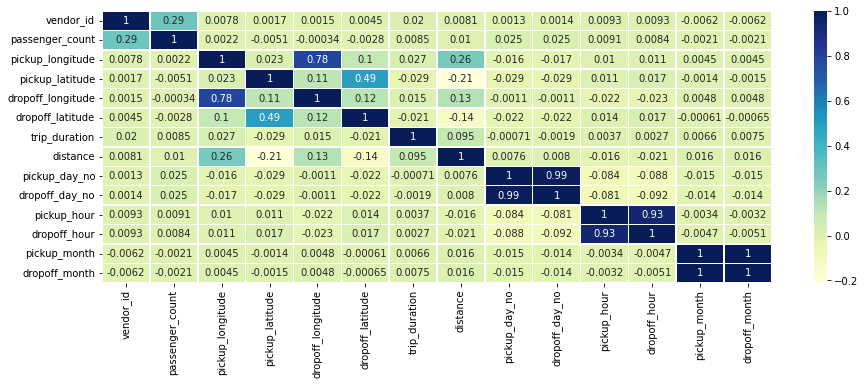

In [15]:
# correlation graph of the data
fig, ax = plt.subplots(figsize=(15,5))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=.5)

  
# displaying heatmap
plt.show()

**Here we can see that the is strongly correlated but the column is important for analysis. further to remove multi collinearity we remove the pickup_month and pickup_day column as pickup_month and dropoff_month has exact same value**

In [22]:
df.drop(['pickup_month'],inplace=True ,axis=1)
df.drop(['pickup_day_no'], inplace=True,axis=1)

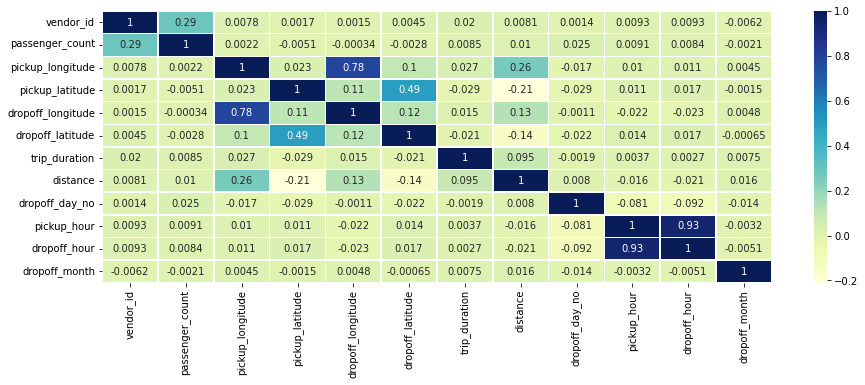

In [23]:
# correlation graph of the data
fig, ax = plt.subplots(figsize=(15,5))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=.5)

  
# displaying heatmap
plt.show()

**Now the data is looking good**

**Checking for outlier in column trip duration**

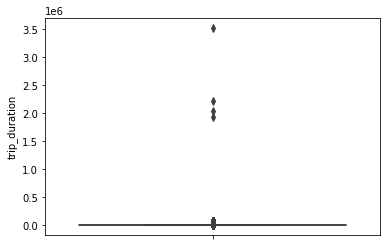

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


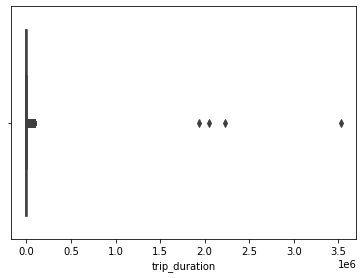

In [26]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y=df['trip_duration'])
plt.show()
columns=['trip_duration']
n = 1
plt.figure(figsize=(20,15))

for column in columns:
  plt.subplot(4,4,n)
  n = n+1
  sns.boxplot(df[column])
  plt.tight_layout()

**You can see that there are some outliers in dataset so we will try to fin 0-100 percentile value  to find a the correct percentile value for removal of outliers**

In [27]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


0 percentile value is 1
10 percentile value is 245
20 percentile value is 348
30 percentile value is 446
40 percentile value is 548
50 percentile value is 662
60 percentile value is 798
70 percentile value is 968
80 percentile value is 1208
90 percentile value is 1634
100 percentile value is  3526282


**We can see that the value of outlier is in the range from 90 to 100 percentile but we do not  know exactly so we do some more step from 90-100**

In [28]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 1634
91 percentile value is 1703
92 percentile value is 1780
93 percentile value is 1869
94 percentile value is 1975
95 percentile value is 2104
96 percentile value is 2273
97 percentile value is 2497
98 percentile value is 2829
99 percentile value is 3440
100 percentile value is  3526282


In [29]:
#calculating 99-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(99.0,100.0,10 ,endpoint=False):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


99.0 percentile value is 3440
99.1 percentile value is 3540
99.2 percentile value is 3652
99.3 percentile value is 3782
99.4 percentile value is 3942
99.5 percentile value is 4139
99.6 percentile value is 4403
99.7 percentile value is 4765
99.8 percentile value is 5552
99.9 percentile value is 85129
100 percentile value is  3526282


**From here we can set the value for trip duration less than 6000 ,otherwise all the values>6000 will be treated as outlier**

In [30]:
df=df[df['trip_duration']<6000]

In [36]:
df.shape

(1456077, 18)

**Daily dropoff analysis**